# Interpreting Anomalies from Isolation Forest


## Isolation Forest

The idea behind Isolation Forest is that anomalies are easier to separate from the rest of the data than other points.  The Isolation Forest algorithm partitions the data through a forest of decision trees.  Each split is made randomly.  The number of splits it takes to isolate a record indicates whether or not the record is an anomaly. When a forest of random trees collectively produces shorter path lengths for particular samples, they are highly likely to be anomalies.

In this demo, we will use the Isolation Forest technique to find employees that may be anomalies.  


## Loading the Data

Before we dive into the anomaly detection, let's initialize the h2o cluster and load our data in. We will be using the [synthetic employee attrition dataset](https://www.ibm.com/communities/analytics/watson-analytics-blog/hr-employee-attrition/). This contains a record per employee with information about their employment history and whether they engaged in attrition.

In [1]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_91"; Java(TM) SE Runtime Environment (build 1.8.0_91-b14); Java HotSpot(TM) 64-Bit Server VM (build 25.91-b14, mixed mode)
  Starting server from /Users/megankurka/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpl241x2j4
  JVM stdout: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpl241x2j4/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/gv/w2f3zs_d33l3dt5j67k9nhhr0000gn/T/tmpl241x2j4/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,4 days
H2O cluster name:,H2O_from_python_megankurka_77x8qj
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [2]:
employee_data = h2o.import_file("./WA_Fn-UseC_-HR-Employee-Attrition.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
employee_data.head()

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0
38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8
36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,3,Male,94,3,2,Healthcare Representative,3,Married,5237,16577,6,Y,No,13,3,2,80,2,17,3,2,7,7,7,7


## Isolation Forests

To find our anomalous employees, let's train our isolation forest and see how the predictions look. We will only use a subset of columns for demo purposes.

In [4]:
from h2o.estimators import H2OIsolationForestEstimator
myX = ['Age', 'BusinessTravel', 'DistanceFromHome', 'Education', 'Gender', 'JobInvolvement', 'JobLevel', 
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

isolation_model = H2OIsolationForestEstimator(model_id = "isolation_forest.hex", seed = 1234)
isolation_model.train(training_frame = employee_data, x = myX)

isolationforest Model Build progress: |███████████████████████████████████| 100%


The predictions from the isolation forest return the `mean_length`.  This is the average number of splits it took to isolate the record across all the decision trees in the forest.  Records with a smaller `mean_length` are more likely to be anomalous since it takes fewer partitions of the data to isolate them.

In [5]:
predictions = isolation_model.predict(employee_data)
predictions.head()

isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
0.120301,6.54
0.037594,6.76
0.180451,6.38
-0.0225564,6.92
-0.0150376,6.9
-0.0451128,6.98
0.172932,6.4
0.0225564,6.8
0.150376,6.46
0.037594,6.76


The histogram of the `mean_length` shows that most employees have a `mean_length` greater than 6.5.  This means that it takes more than 6 splits on average to partition them.  

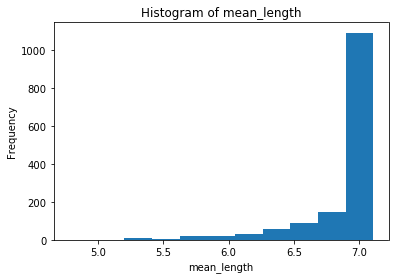

In [6]:
predictions["mean_length"].hist()

## Defining Anomalies

We will define an anomaly as an employee who's `mean_length` is less than 5.5.  These were employees who were easier to isolate from the rest of the data.

There are 34 anomalous employees.

In [7]:
anomalies = employee_data[predictions["mean_length"] < 5.5]
print("Number of Anomalies: " + str(anomalies.nrow))

Number of Anomalies: 34


In [8]:
isolation_model.predict(anomalies)["mean_length"].cbind(anomalies[myX])

isolationforest prediction progress: |████████████████████████████████████| 100%


mean_length,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobInvolvement,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
5.48,59,Travel_Rarely,25,3,Female,3,3,Single,7637,7,No,11,3,28,3,21,16,7,9
5.38,58,Travel_Rarely,10,4,Male,3,4,Single,13872,0,No,13,3,38,1,37,10,1,8
5.4,59,Non-Travel,2,4,Female,2,5,Married,18844,9,No,21,4,30,3,3,2,2,2
4.88,51,Travel_Rarely,6,3,Male,3,5,Single,19537,7,No,13,3,23,5,20,18,15,15
4.92,58,Travel_Rarely,23,4,Female,3,3,Married,10312,1,No,12,3,40,3,40,10,15,6
5.48,46,Travel_Rarely,1,2,Female,3,3,Divorced,10453,1,No,25,4,24,2,24,13,15,7
4.92,55,Travel_Rarely,14,4,Male,4,5,Single,18722,8,No,11,3,36,3,24,15,2,15
5.04,52,Travel_Rarely,1,4,Male,2,5,Married,19999,0,No,14,3,34,5,33,18,11,9
5.04,52,Non-Travel,2,4,Male,2,5,Single,19068,1,Yes,18,3,33,2,33,7,15,12
4.92,55,Travel_Rarely,1,3,Male,3,5,Single,19045,0,Yes,14,3,37,2,36,10,4,13


## Interpreting Anomalies

There are two levels of interpretation:

* global level: high level understanding of what segments of data are considered anomalous
* local level: understanding of why an individual record is considered anomalous

We will start with the global level.  Our goal is to gain an understanding of what segments of data are considered anomalous.

### Global Level

Now that we have found anomalous employees, we are interested in why they are considered anomalies.  To do this, we will train a surrogate decision tree.  The purpose of the surrogate decision tree is to find records with the anomaly flag.  To do this, it will find segments of similar anomalies and discover how to separate them from records that are not anomalies.  We can use this decision tree to then describe anomalous segments of the data.

The steps of interpreting anomalies on a global level are:

1. Create a frame with a column that indicates whether the record was considered an anomaly.
2. Train a decision tree to predict the anomaly flag.
3. Visualize the decision tree to determine which segments of the data are considered anomalous.

In our first step, we will add a column called `anomaly`.  This is a flag that indicates whether the isolation forest considered the record an anomaly.

In [14]:
global_surrogate_data = employee_data[:, :]
global_surrogate_data["anomaly"] = (predictions["mean_length"] < 5.5).ifelse("Yes", "No")
global_surrogate_data["anomaly"].table()

anomaly,Count
No,1436
Yes,34


Now that we have the surrogate data, we can train a single decision tree to predict the anomaly flag.  We will keep this decision tree simple (only a single decision tree with a depth of 3) because the purpose of the decision tree is to be completely interpretable.

In [18]:
from h2o.estimators import H2ORandomForestEstimator

global_surrogate_dt = H2ORandomForestEstimator(model_id = "global_surrogate_decision_tree.hex", 
                                               ntrees = 1, max_depth = 3,
                                               sample_rate = 1, mtries = len(myX))
global_surrogate_dt.train(training_frame = global_surrogate_data, x = myX, y = "anomaly")

drf Model Build progress: |███████████████████████████████████████████████| 100%


We can now visualize the decision tree to find segments of the data that are anomalous.

In [19]:
import os
import subprocess
from IPython.display import Image
def generateTreeImage(decision_tree, image_file_path):
    # Download MOJO
    mojo_path = decision_tree.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    gv_call = " ".join(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree 0 -i", mojo_path , "-o", gv_file_path])
    result = subprocess.call(gv_call, shell=True)
    result = subprocess.call(["ls", gv_file_path], shell = False)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o", image_file_path], shell=False)
    result = subprocess.call(["ls",image_file_path], shell = False)
    
    return Image(image_file_path)

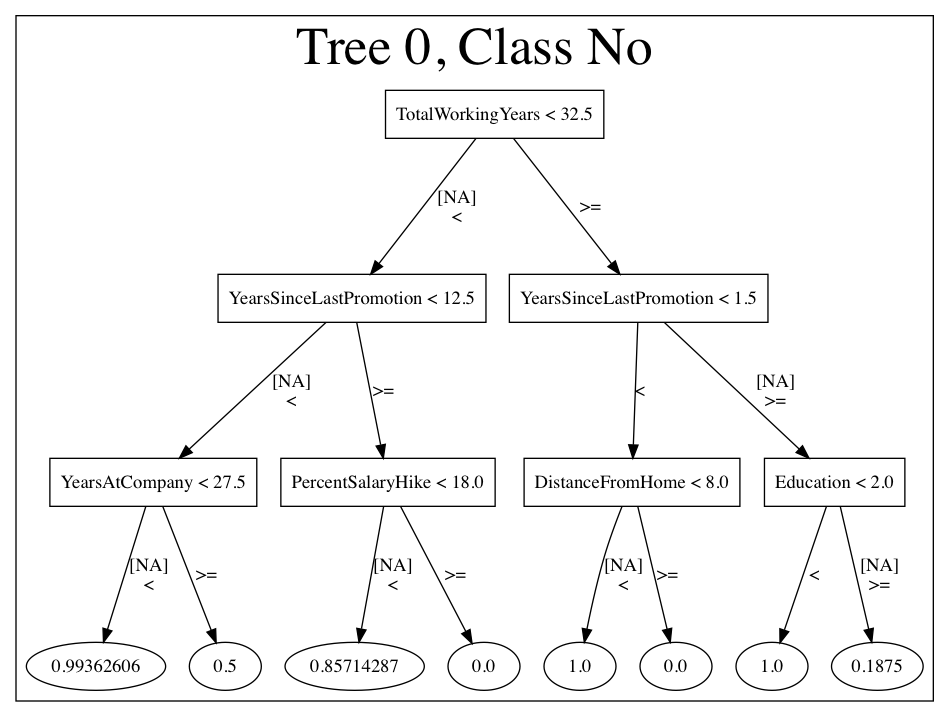

In [20]:
generateTreeImage(global_surrogate_dt, "./global_surrogate_decision_tree.png")

The visualization shows our global surrogate decision tree.  The values in the leaf nodes represent the probability of the record not being an anomaly.  We are, therefore, interested in leaf nodes with low values - these will indicate a segment of data that is anomalous.

We can see that there are three leaf nodes with all anomalies.  One leaf node is defined as: 

* Total Working Years < 32.5
* Years Since Last Promotion < 12.5
* Percent Salary Hike >= 18.0

This segment seems strange for two reasons: 

* the employees have been working 32 years or less but have not received a promotion for more than 12 years
    * most employees have a promotion ever 4 years of working 
* the employee has not had a promotion recently but has received a large salary hike
    * years since last promotion is negatively correlated with salary hike

In [47]:
promotion_per_working_years = employee_data[employee_data["YearsSinceLastPromotion"] > 0]
promotion_per_working_years = promotion_per_working_years["TotalWorkingYears"]/promotion_per_working_years["YearsSinceLastPromotion"]
promotion_per_working_years.median()

[4.0]

In [24]:
employee_data[["YearsSinceLastPromotion", "PercentSalaryHike"]].cor()

YearsSinceLastPromotion,PercentSalaryHike
1,-0.0221543
-0.0221543,1


### Local Level

Now we will perform a local level interpretation.  The goal of this interpretation is to determine why a specific employee is considered an anomaly.

The steps of interpreting anomalies on a local level are:

1. Create a frame with a column that indicates whether the record is our selected anomaly.
2. Train a decision tree to predict the anomaly flag.
3. Visualize the decision tree to determine how the selected anomaly separates from the rest of the dat.a.

Let's begin by examining our first anomaly.

In [48]:
anomalies[0, myX]

Age,BusinessTravel,DistanceFromHome,Education,Gender,JobInvolvement,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
59,Travel_Rarely,25,3,Female,3,3,Single,7637,7,No,11,3,28,3,21,16,7,9


In [49]:
isolation_model.predict(anomalies[0, :])

isolationforest prediction progress: |████████████████████████████████████| 100%


predict,mean_length
0.518797,5.48


To determine why this employee is considered anomalous, we will build a surrogate decision tree.  The goal of the decision tree is to separate this employee from all other employees.

The structure of the decision tree will tell us why the employee is different from others.

In [54]:
local_surrogate_data = employee_data[:, :]
local_surrogate_data["anomaly_record"] = (local_surrogate_data["EmployeeNumber"] == 81).ifelse("Anomaly", "NotAnomaly")

In [55]:
local_surrogate_data["anomaly_record"].table()

anomaly_record,Count
NotAnomaly,1469
Anomaly,1


In [56]:
local_surrogate_dt = H2ORandomForestEstimator(model_id = "local_level_surrogate_decision_tree.hex", 
                                              ntrees = 1, max_depth = 3,
                                              sample_rate = 1, mtries = len(myX))
local_surrogate_dt.train(training_frame = local_surrogate_data, x = myX, y = "anomaly_record")

drf Model Build progress: |███████████████████████████████████████████████| 100%


We can visualize this decision tree to see how it split to isolate our anomaly record.

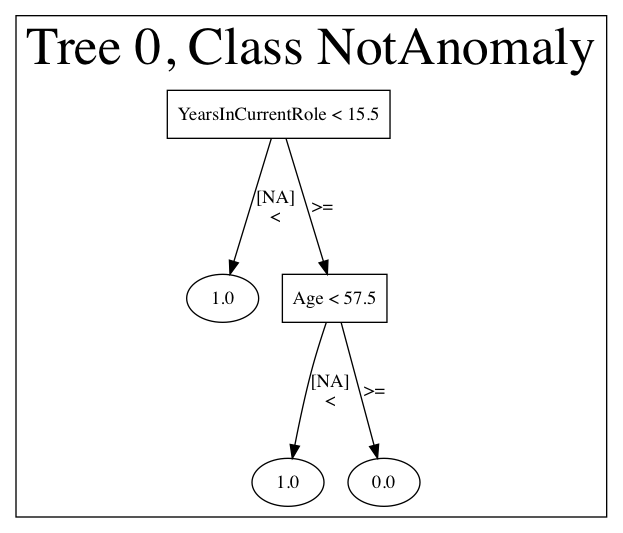

In [57]:
generateTreeImage(local_surrogate_dt, "./global_surrogate_decision_tree.png")

The anomalous employee falls in the bucket of employees with a high number of years in the Current Role and Age. It falls in the bucket: `YearsInCurrentRole >= 15.5` and `Age >= 57.5`.  

We can see that our simple decision tree is perfectly able to separate the anomaly from the other employees because it has an AUC of 1.  This means that this employee is the only one in the data that has been in his/her current role more than 15.5 years and is older than 57.

In [58]:
local_surrogate_dt.model_performance(surrogate_data).auc()

1.0

In [59]:
anomalies[0, ["Age", "YearsInCurrentRole"]]

Age,YearsInCurrentRole
59,16


If we examine the distribution of these two features, we can see that the employee falls on the right of the spectrum for both.

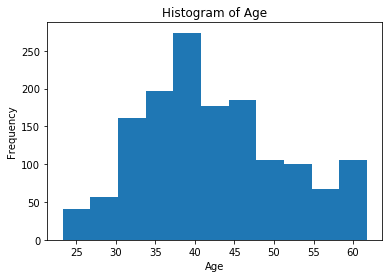

In [60]:
employee_data["Age"].hist()

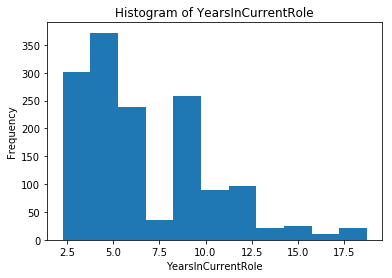

In [61]:
employee_data["YearsInCurrentRole"].hist()